Epoch 1/100
1/1 [==============================] - 6s 6s/step - loss: 1.1582e-08 - mae: 7.9297e-05
Epoch 2/100
1/1 [==============================] - 1s 927ms/step - loss: 8.4752e-10 - mae: 2.0701e-05
Epoch 3/100
1/1 [==============================] - 1s 873ms/step - loss: 7.7824e-10 - mae: 1.9972e-05
Epoch 4/100
1/1 [==============================] - 1s 802ms/step - loss: 7.2161e-10 - mae: 1.9352e-05
Epoch 5/100
1/1 [==============================] - 1s 915ms/step - loss: 6.7437e-10 - mae: 1.8821e-05
Epoch 6/100
1/1 [==============================] - 1s 760ms/step - loss: 6.3434e-10 - mae: 1.8360e-05
Epoch 7/100
1/1 [==============================] - 0s 363ms/step - loss: 5.9998e-10 - mae: 1.7952e-05
Epoch 8/100
1/1 [==============================] - 0s 339ms/step - loss: 5.7016e-10 - mae: 1.7589e-05
Epoch 9/100
1/1 [==============================] - 0s 355ms/step - loss: 5.4404e-10 - mae: 1.7263e-05
Epoch 10/100
1/1 [==============================] - 0s 335ms/step - loss: 5.2098e-10 

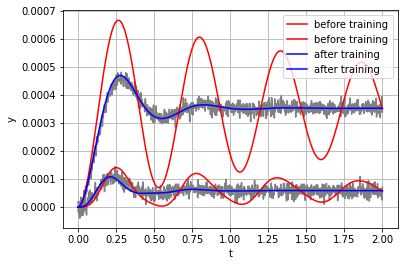

In [2]:
import tensorflow as tf
#original
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import RNN, Layer
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow import float32, concat, convert_to_tensor, linalg

class RungeKuttaIntegratorCell(Layer):
    def __init__(self, m, c, k, dt, initial_state, **kwargs):
        super(RungeKuttaIntegratorCell, self).__init__(**kwargs)
        self.Minv = linalg.inv(np.diag(m))
        self._c   = c
        self.K    = self._getCKmatrix(k)
        self.initial_state = initial_state
        self.state_size    = 2*len(m)
        self.A  = np.array([0., 0.5, 0.5, 1.0], dtype='float32')
        self.B  = np.array([[1/6, 2/6, 2/6, 1/6]], dtype='float32')
        self.dt = dt

    def build(self, input_shape, **kwargs):
        self.kernel = self.add_weight("C", shape = self._c.shape, trainable = True, initializer = lambda shape, dtype: self._c, **kwargs)
        self.built  = True

    def call(self, inputs, states):
        C    = self._getCKmatrix(self.kernel)
        y    = states[0][:,:2]
        ydot = states[0][:,2:]
        yddoti = self._fun(self.Minv, self.K, C, inputs, y, ydot)
        yi     = y + self.A[0] * ydot * self.dt
        ydoti  = ydot + self.A[0] * yddoti * self.dt
        fn     = self._fun(self.Minv, self.K, C, inputs, yi, ydoti)
        for j in range(1,4):
            yn    = y + self.A[j] * ydot * self.dt
            ydotn = ydot + self.A[j] * yddoti * self.dt
            ydoti = concat([ydoti, ydotn], axis=0)
            fn    = concat([fn, self._fun(self.Minv, self.K, C, inputs, yn, ydotn)], axis=0)
        y    = y + linalg.matmul(self.B, ydoti) * self.dt
        ydot = ydot + linalg.matmul(self.B, fn) * self.dt
        return y, [concat(([y, ydot]), axis=-1)]

    def _fun(self, Minv, K, C, u, y, ydot):
        return linalg.matmul(u - linalg.matmul(ydot, C, transpose_b=True) - linalg.matmul(y, K, transpose_b=True), Minv, transpose_b=True)

    def _getCKmatrix(self, a):
        return convert_to_tensor([[a[0]+a[1],-a[1]],[-a[1],a[1]+a[2]]], dtype=float32)

    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        return self.initial_state


def create_model(m, c, k, dt, initial_state, batch_input_shape, return_sequences = True, unroll = False):
    rkCell = RungeKuttaIntegratorCell(m=m, c=c, k=k, dt=dt, initial_state=initial_state)
    PINN   = RNN(cell=rkCell, batch_input_shape=batch_input_shape, return_sequences=return_sequences, return_state=False, unroll=unroll)
    model  = Sequential()
    model.add(PINN)
    model.compile(loss='mse', optimizer=RMSprop(1e4), metrics=['mae'])
    return model

if __name__ == "__main__":
    # masses, spring coefficients, and damping coefficients
    m = np.array([20.0, 10.0], dtype='float32')
    c = np.array([10.0, 10.0, 10.0], dtype='float32') # initial guess
    k = np.array([2e3, 1e3, 5e3], dtype='float32')

    # data
    df = pd.read_csv('data.csv')
    t  = df[['t']].values
    dt = (t[1] - t[0])[0]
    utrain = df[['u0', 'u1']].values[np.newaxis, :, :]
    ytrain = df[['yT0', 'yT1']].values[np.newaxis, :, :]
    # fitting physics-informed neural network
    initial_state = np.zeros((1,2 * len(m),), dtype='float32')
    model = create_model(m, c, k, dt, initial_state=initial_state, batch_input_shape=utrain.shape)
    yPred_before = model.predict_on_batch(utrain)[0, :, :]
    model.fit(utrain, ytrain, epochs=100, steps_per_epoch=1, verbose=1)
    yPred = model.predict_on_batch(utrain)[0, :, :]

    # plotting prediction results
    plt.plot(t, ytrain[0, :, :], 'gray')
    plt.plot(t, yPred_before[:, :], 'r', label='before training')
    plt.plot(t, yPred[:, :], 'b', label='after training')
    plt.xlabel('t')
    plt.ylabel('y')
    plt.grid('on')
    plt.legend()
    plt.show()